<a href="https://colab.research.google.com/github/fathimayusuff/COMP5206/blob/master/COMP_5206_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import math
%matplotlib inline
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Twitter Data Import

In [4]:
data = pd.read_csv("/content/drive/My Drive/Tweets_air.csv") 
data.head
display(data)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760000,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,=@VirginAmerica What @dhepburn said.,NaN,42059.483241,NaN,Eastern Time (US & Canada)
1,570301130888122000,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,42059.469433,NaN,Pacific Time (US & Canada)
2,570301083672813000,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,42059.469306,Lets Play,Central Time (US & Canada)
3,570301031407624000,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,42059.469167,NaN,Pacific Time (US & Canada)
4,570300817074462000,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,42059.468576,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825000,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,=@AmericanAir Thank you we got on a different ...,NaN,42057.500706,NaN,NaN
14636,569587371693355000,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,42057.499838,Texas,NaN
14637,569587242672398000,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,42057.499479,"Nigeria,lagos",NaN
14638,569587188687634000,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,42057.499329,New Jersey,Eastern Time (US & Canada)


In [5]:
data.shape

(14640, 15)

In [6]:
data.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [7]:
data[['text', 'airline_sentiment']].head()

,text,airline_sentiment
0,=@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [8]:
data['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

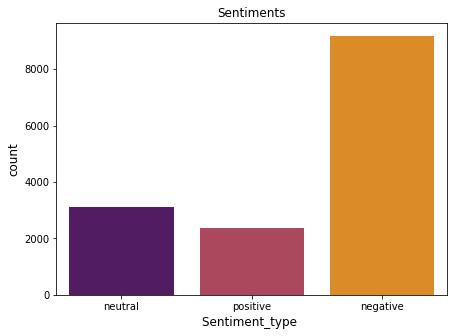

In [9]:
plt.rcParams['figure.figsize'] = (7, 5)
size = [10551, 1694]
sns.countplot(data['airline_sentiment'], palette = 'inferno')
plt.title('Sentiments', fontsize = 12)
plt.xlabel('Sentiment_type ', fontsize = 12)
plt.ylabel('count', fontsize = 12)
plt.show()

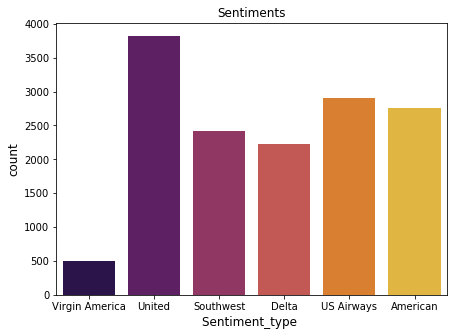

In [10]:
plt.rcParams['figure.figsize'] = (7, 5)
size = [10551, 1694]
sns.countplot(data['airline'], palette = 'inferno')
plt.title('Sentiments', fontsize = 12)
plt.xlabel('Sentiment_type ', fontsize = 12)
plt.ylabel('count', fontsize = 12)
plt.show()

In [0]:
data['airline_sentiment'] = data['airline_sentiment'].replace('neutral', 1)
data['airline_sentiment'] = data['airline_sentiment'].replace('negative', 0)
data['airline_sentiment'] = data['airline_sentiment'].replace('positive', 2)

In [0]:
X = data['text'] # data
y = data['airline_sentiment'] # labels

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [0]:
t = Tokenizer()
t.fit_on_texts(X)

In [15]:
vocab_size = len(t.word_index) + 1
vocab_size

15776

In [0]:
sequences = t.texts_to_sequences(X)

In [0]:
def max_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

In [18]:
tweet_num = max_tweet()
tweet_num

30

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = tweet_num
padded_X = pad_sequences(sequences, padding='post', maxlen=maxlen)

In [0]:
labels = to_categorical(np.asarray(y))

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_X, labels, test_size = 0.2, random_state = 0)

In [22]:
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (11712, 30)
y_train size: (11712, 3)
X_test size: (2928, 30)
y_test size: (2928, 3)


Glove embedding

In [0]:
f = open('/content/drive/My Drive/glove.6B.100d.txt')

In [24]:
embeddings_index = dict()
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
# Define size of embedding matrix: number of unique words x embedding dim (100)
embedding_matrix = np.zeros((vocab_size, 100))

# fill in matrix
for word, i in t.word_index.items():  # dictionary
    embedding_vector = embeddings_index.get(word) # gets embedded vector of word from GloVe
    if embedding_vector is not None:
        # add to matrix
        embedding_matrix[i] = embedding_vector # each row of matrix


In [26]:
from tensorflow.keras.layers import Embedding

# input is vocab_size, output is 100
# weights from embedding matrix, set trainable = False
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                           input_length = tweet_num, trainable=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D


Using TensorFlow backend.


# Simple LSTM

In [28]:
lstm_mod1 = Sequential()
lstm_mod1.add(embedding_layer)
lstm_mod1.add(LSTM(256, dropout = 0.4, 
               recurrent_dropout = 0.5))
lstm_mod1.add(Dense(3, activation='softmax'))
lstm_mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod1.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1577600   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 1,943,939
Trainable params: 366,339
Non-trainable params: 1,577,600
_________________________________________________________________


In [29]:
hist_1 = lstm_mod1.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 9369 samples, validate on 2343 samples
Epoch 1/100
9369/9369 [==============================] - 4s 404us/sample - loss: 0.8723 - acc: 0.6184 - val_loss: 0.8380 - val_acc: 0.6402
Epoch 2/100
9369/9369 [==============================] - 2s 184us/sample - loss: 0.8219 - acc: 0.6548 - val_loss: 0.7507 - val_acc: 0.6914
Epoch 3/100
9369/9369 [==============================] - 2s 182us/sample - loss: 0.7737 - acc: 0.6834 - val_loss: 0.6995 - val_acc: 0.7187
Epoch 4/100
9369/9369 [==============================] - 2s 182us/sample - loss: 0.7548 - acc: 0.6936 - val_loss: 0.6789 - val_acc: 0.7303
Epoch 5/100
9369/9369 [==============================] - 2s 182us/sample - loss: 0.7326 - acc: 0.7015 - val_loss: 0.6607 - val_acc: 0.7384
Epoch 6/100
9369/9369 [==============================] - 2s 185us/sample - loss: 0.7062 - acc: 0.7095 - val_loss: 0.6402 - val_acc: 0.7542
Epoch 7/100
9369/9369 [=

In [30]:

# Find train and test accuracy
loss, accuracy = lstm_mod1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9137
Testing Accuracy:  0.8023


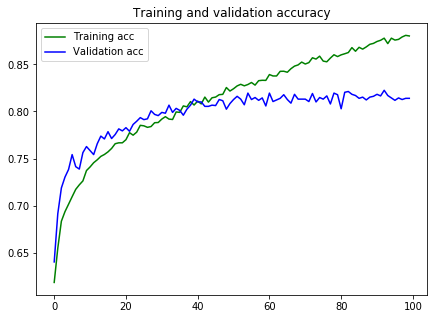

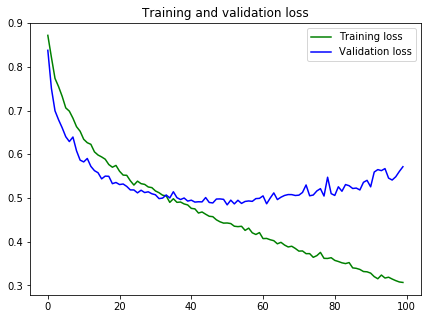

In [31]:
acc = hist_1.history['acc']
val_acc = hist_1.history['val_acc']
loss = hist_1.history['loss']
val_loss = hist_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
print (embedding_layer.output_shape)

(None, 30, 100)


# CNN 

In [33]:
lstm_mod2 = Sequential()
lstm_mod2.add(embedding_layer)
lstm_mod2.add(Conv1D(128, 5, activation='relu'))
lstm_mod2.add(GlobalMaxPooling1D())
lstm_mod2.add(Dense(10, activation='relu'))
lstm_mod2.add(Dense(3, activation='sigmoid'))
lstm_mod2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1577600   
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 1,643,051
Trainable params: 65,451
Non-trainable params: 1,577,600
_________________________________________________________________


In [34]:
hist_2 = lstm_mod2.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Train on 9369 samples, validate on 2343 samples
Epoch 1/100
9369/9369 [==============================] - 5s 506us/sample - loss: 0.8165 - acc: 0.6489 - val_loss: 0.7360 - val_acc: 0.6854
Epoch 2/100
9369/9369 [==============================] - 0s 18us/sample - loss: 0.6569 - acc: 0.7180 - val_loss: 0.6600 - val_acc: 0.7260
Epoch 3/100
9369/9369 [==============================] - 0s 16us/sample - loss: 0.5512 - acc: 0.7838 - val_loss: 0.6034 - val_acc: 0.7512
Epoch 4/100
9369/9369 [==============================] - 0s 16us/sample - loss: 0.4792 - acc: 0.8160 - val_loss: 0.5633 - val_acc: 0.7725
Epoch 5/100
9369/9369 [==============================] - 0s 18us/sample - loss: 0.4082 - acc: 0.8456 - val_loss: 0.5600 - val_acc: 0.7776
Epoch 6/100
9369/9369 [==============================] - 0s 17us/sample - loss: 0.3542 - acc: 0.8733 - val_loss: 0.5487 - val_acc: 0.7832
Epoch 7/100
9369/9369 [==============================] - 0s 17us/sample - loss: 0.3142 - acc: 0.8964 - val_loss: 0.5425 - v

In [35]:

# Find train and test accuracy
loss, accuracy = lstm_mod2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9500
Testing Accuracy:  0.7643


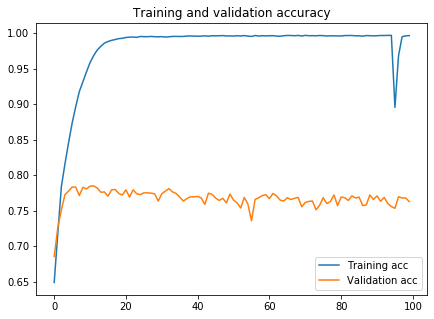

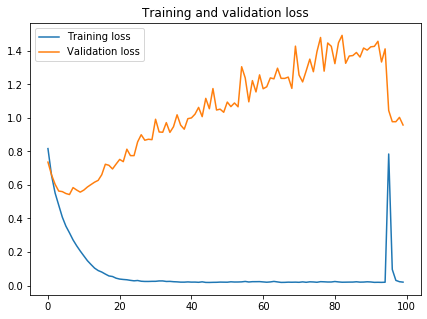

In [36]:
acc = hist_2.history['acc']
val_acc = hist_2.history['val_acc']
loss = hist_2.history['loss']
val_loss = hist_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Simple RNN

In [0]:
from tensorflow.keras.layers import SimpleRNN

In [38]:
lstm_mod3 = Sequential()
lstm_mod3.add(embedding_layer)
lstm_mod3.add(SimpleRNN(256))
#lstm_mod3.add(Dense(3, activation='tanh'))
lstm_mod3.add(Dense(3, activation='relu'))
lstm_mod3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1577600   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 256)               91392     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 1,669,763
Trainable params: 92,163
Non-trainable params: 1,577,600
_________________________________________________________________


In [39]:
hist_3 = lstm_mod3.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Train on 9369 samples, validate on 2343 samples
Epoch 1/100
9369/9369 [==============================] - 1s 65us/sample - loss: 1.1761 - acc: 0.5962 - val_loss: 0.9186 - val_acc: 0.6176
Epoch 2/100
9369/9369 [==============================] - 0s 38us/sample - loss: 0.9086 - acc: 0.6256 - val_loss: 0.9101 - val_acc: 0.6176
Epoch 3/100
9369/9369 [==============================] - 0s 37us/sample - loss: 0.8694 - acc: 0.6288 - val_loss: 0.8506 - val_acc: 0.6240
Epoch 4/100
9369/9369 [==============================] - 0s 38us/sample - loss: 0.8464 - acc: 0.6327 - val_loss: 0.8419 - val_acc: 0.6359
Epoch 5/100
9369/9369 [==============================] - 0s 38us/sample - loss: 0.8329 - acc: 0.6502 - val_loss: 0.8631 - val_acc: 0.6436
Epoch 6/100
9369/9369 [==============================] - 0s 37us/sample - loss: 2.3098 - acc: 0.6319 - val_loss: 1.7706 - val_acc: 0.6176
Epoch 7/100
9369/9369 [==============================] - 0s 39us/sample - loss: 1.0617 - acc: 0.3904 - val_loss: 1.0071 - va

In [40]:

# Find train and test accuracy
loss, accuracy = lstm_mod3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6240
Testing Accuracy:  0.6387


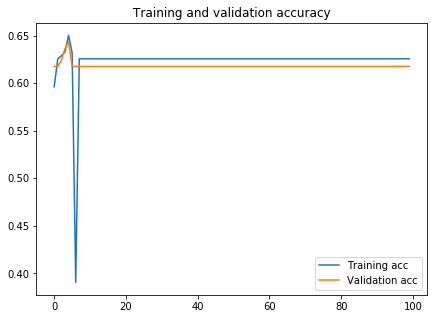

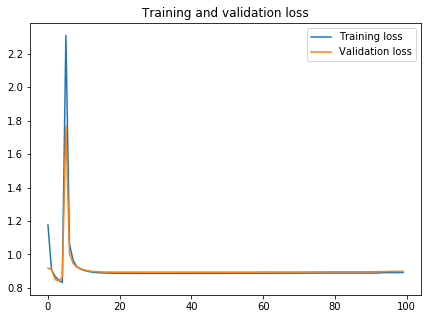

In [41]:
acc = hist_3.history['acc']
val_acc = hist_3.history['val_acc']
loss = hist_3.history['loss']
val_loss = hist_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
mod = Sequential()
mod.add(embedding_layer)
mod.add(Conv1D(128, 5, activation='relu'))
mod.add(Conv1D(128, 5, activation='relu'))
mod.add(Conv1D(128, 5, activation='relu'))
mod.add(SimpleRNN(64))
mod.add(Dense(3, activation='sigmoid'))
mod.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [43]:
hist_5 = mod.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Train on 9369 samples, validate on 2343 samples
Epoch 1/100
9369/9369 [==============================] - 1s 89us/sample - loss: 0.8592 - acc: 0.6273 - val_loss: 0.8482 - val_acc: 0.6287
Epoch 2/100
9369/9369 [==============================] - 0s 43us/sample - loss: 0.8283 - acc: 0.6524 - val_loss: 0.8108 - val_acc: 0.6637
Epoch 3/100
9369/9369 [==============================] - 0s 45us/sample - loss: 0.7783 - acc: 0.6757 - val_loss: 0.7738 - val_acc: 0.6598
Epoch 4/100
9369/9369 [==============================] - 0s 44us/sample - loss: 0.7084 - acc: 0.7128 - val_loss: 0.7365 - val_acc: 0.6927
Epoch 5/100
9369/9369 [==============================] - 0s 45us/sample - loss: 0.6116 - acc: 0.7557 - val_loss: 0.6459 - val_acc: 0.7426
Epoch 6/100
9369/9369 [==============================] - 0s 43us/sample - loss: 0.5246 - acc: 0.7930 - val_loss: 0.6271 - val_acc: 0.7516
Epoch 7/100
9369/9369 [==============================] - 0s 44us/sample - loss: 0.5165 - acc: 0.7962 - val_loss: 0.6679 - va

In [44]:
mod.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1577600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 128)           64128     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 128)           82048     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 18, 128)           82048     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
Total params: 1,818,371
Trainable params: 240,771
Non-trainable params: 1,577,600
______________________________________

In [45]:
loss, accuracy = mod.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mod.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9481
Testing Accuracy:  0.7442


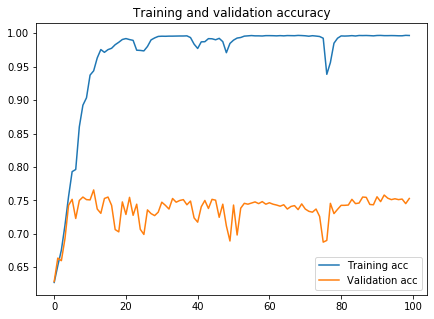

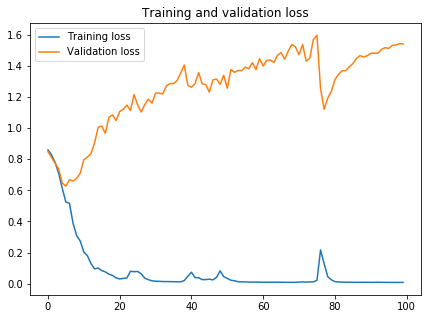

In [46]:
acc = hist_5.history['acc']
val_acc = hist_5.history['val_acc']
loss = hist_5.history['loss']
val_loss = hist_5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Naive Bayes using NLP

In [0]:
pos = data.loc[data['airline_sentiment'].isin([1])]
pos_tweets=pos.text.to_list()

neg = data.loc[data['airline_sentiment'].isin([0])]
neg_tweets=neg.text.to_list()

neutral = data.loc[data['airline_sentiment'].isin([2])]
neutral_tweets=neutral.text.to_list()

In [48]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
 
for tweet in pos_tweets[:5]:
    print (tweet_tokenizer.tokenize(tweet))

['=', 'what', 'said', '.']
['i', "didn't", 'today', '...', 'must', 'mean', 'i', 'need', 'to', 'take', 'another', 'trip', '!']
['really', 'missed', 'a', 'prime', 'opportunity', 'for', 'men', 'without', 'hats', 'parody', ',', 'there', '.', 'https://t.co/mWpG7grEZP']
['did', 'you', 'know', 'that', 'suicide', 'is', 'the', 'second', 'leading', 'cause', 'of', 'death', 'among', 'teens', '10-24']
['will', 'you', 'be', 'making', 'bos', '>', 'las', 'non', 'stop', 'permanently', 'anytime', 'soon', '?']


In [49]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import string
import re
 
from nltk.corpus import stopwords 
stopwords_english = stopwords.words('english')
 
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")
 
from nltk.tokenize import TweetTokenizer

In [51]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 

emoticons = emoticons_happy.union(emoticons_sad)

def hashtags(tweet):
        return list(filter(lambda token: token.startswith('#'), tweet.split())) 

def clean_tweets(tweet):
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
 
    # remove retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
 
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
      tweet = re.sub(r'#', '', tweet)
   
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
 
    tweets_clean = []    
    for word in tweet_tokens:
        if (word not in stopwords_english and # remove stopwords
              word not in emoticons and # remove emoticons
                word not in string.punctuation): # remove punctuation
            
            stem_word = stemmer.stem(word) # stemming word
            tweets_clean.append(stem_word)
 
    return tweets_clean
 
custom_tweet = "RT @Twitter @online Hello There! Have a great day. :)"
print (clean_tweets(custom_tweet))
print (pos_tweets[5])
print (clean_tweets(pos_tweets[5]))

IndentationError: ignored

In [0]:
def bag_of_words(tweet):
    words = clean_tweets(tweet)
    words_dictionary = dict([word, True] for word in words)    
    return words_dictionary
 
custom_tweet = "RT @Twitter @online Hello There! Have a great day. :)"
print (bag_of_words(custom_tweet))

# positive tweets feature set
pos_tweets_set = []
hashtag_bag=[]
for tweet in pos_tweets:
    hashtag_bag.append(hashtags(tweet))
    pos_tweets_set.append((bag_of_words(tweet), 'pos'))    
 
# negative tweets feature set
neg_tweets_set = []
for tweet in neg_tweets:
    hashtag_bag.append(hashtags(tweet))
    neg_tweets_set.append((bag_of_words(tweet), 'neg'))

# negative tweets feature set
neutral_tweets_set = []
for tweet in neutral_tweets:
    hashtag_bag.append(hashtags(tweet))
    neutral_tweets_set.append((bag_of_words(tweet), 'neutral'))
 
print (len(pos_tweets_set), len(neg_tweets_set), len(neutral_tweets_set))

In [0]:
print(neg_tweets_set)

In [0]:
list2 = [x for x in hashtag_bag if x != []]
print(list2)

In [0]:
from random import shuffle 
shuffle(pos_tweets_set)
shuffle(neg_tweets_set)
shuffle(neutral_tweets_set)
 
test_set = pos_tweets_set[:1000] + neg_tweets_set[:1000] 
train_set = pos_tweets_set[1000:] + neg_tweets_set[1000:]
 
print(len(test_set),  len(train_set)) 

In [0]:
from nltk import classify
from nltk import NaiveBayesClassifier
 
classifier = NaiveBayesClassifier.train(train_set)
accuracy = classify.accuracy(classifier, test_set)
print(accuracy)
print (classifier.show_most_informative_features(10))    

In [0]:
custom_tweet = "Being Human"
custom_tweet_set = bag_of_words(custom_tweet)
print (classifier.classify(custom_tweet_set)) 
 
# probability result
prob_result = classifier.prob_classify(custom_tweet_set)
print (prob_result) 
print (prob_result.max())
print (prob_result.prob("neg"))
print (prob_result.prob("pos"))
 

In [0]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
import re

In [0]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt
data['tidy_tweet'] = np.vectorize(remove_pattern)(data['text'], "@[\w]*")
# remove special characters, numbers, punctuations
data['tidy_tweet'] = data['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
# remove words less than 3 characters long
data['tidy_tweet'] = data['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
stopwords = set(STOPWORDS)

In [0]:
pos1 = data.loc[data['airline_sentiment'].isin([2])]
pos_high_conf=pos1.text.to_list()
print(pos_high_conf[5])

neg1 = data.loc[data['airline_sentiment'].isin([0])]
neg_high_conf=neg1.text.to_list()
print(neg_high_conf[5])

neutral1 = data.loc[data['airline_sentiment'].isin([1])]
neutral_high_conf=neutral1.text.to_list()
print(neutral_high_conf[5])

In [0]:
neg1['tidy_tweet']

In [0]:
wordcloud = WordCloud(
                    background_color='white',
                    stopwords=stopwords,
                    max_words=75,
                    max_font_size=40,
                    random_state=42).generate(str(pos1['tidy_tweet']))
 
print(wordcloud)
fig = plt.figure(1, figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear', cmap='viridis')
plt.axis('off')
plt.show()

In [0]:
wordcloud1 = WordCloud(
                    background_color='white',
                    stopwords=stopwords,
                    max_words=75,
                    max_font_size=40,
                    random_state=42).generate(str(neg1['tidy_tweet']))
 
print(wordcloud1)
fig = plt.figure(1, figsize=(10,5))
plt.imshow(wordcloud1, interpolation='bilinear', cmap='viridis')
plt.axis('off')
plt.show()